Conversor de Mapa

O seguinte algoritmo tem como principal função converter um conjunto de arquivos (.yaml e .pgm) em um mapa visualizavel e extrair os pontos 
pertencentes a linha de centro desse mesmo algortimo.

Segue as etapas:    É aplicado o EDT no mapa para  obter suas distancias.
                    Em cima dos resultados obtidos pelo EDT, aplicamos a função Skeletonize para obter a linha de centro.
                    Após isso, aplicamos um algoritmo de DFS para extrair a linha de centro(posição e largura dos pontos)
                    Por fim, o algoritmo converte as coordenadas de pixel para metros.

Nota importante: A imagem do mapa deve ser um arquivo .pgm com as bordas bem definidas e suaves, a parte de dentro do mapa branca, a de fora
cinza e as paredes pretas.

In [61]:
import numpy as np
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import yaml
import scipy
from scipy.ndimage import distance_transform_edt as edt
from PIL import Image
import os

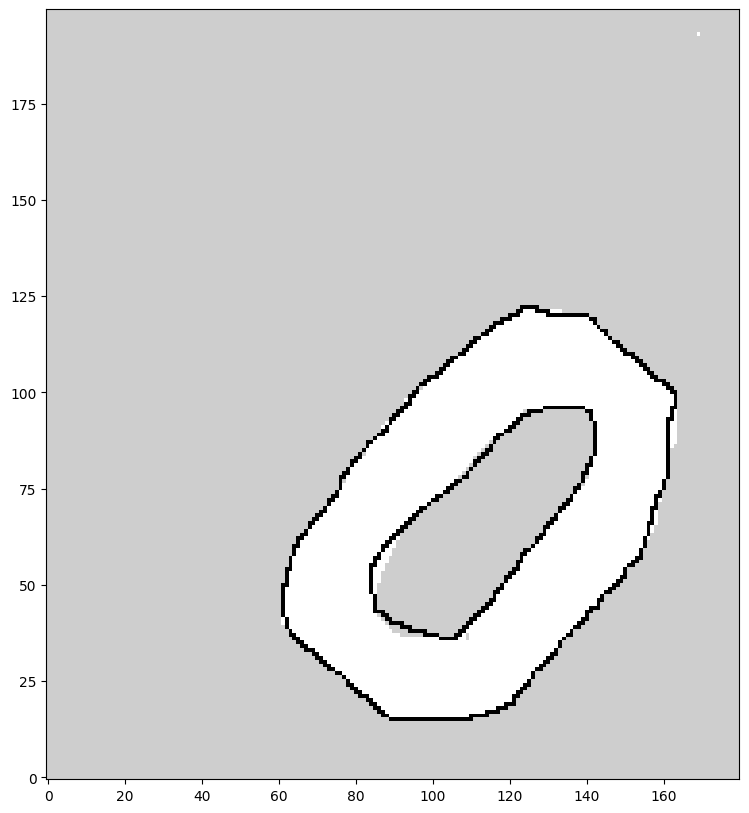

In [62]:
# Esse bloco de código verifica a existencia do arquivo e prepara a imagem para as próximas etapas

nomeMapa = "pingpong_clean" # Define o nome do mapa

margemLargurapista = 0.0

if os.path.exists(f"maps/{nomeMapa}.pgm"): # Verifica se o nome do mapa existe na pasta maps/, caso exista, define uma variável. Caso contrário reporta um erro.
    caminhoMapa = f"maps/{nomeMapa}.pgm"
else:
    raise Exception("Mapa não encontrado, por gentileza verificar o diretório")

mapaYaml = f"maps/{nomeMapa}.yaml" # Define a variavel do mapa como o arquivo .yaml,
imagemMapaV0 = np.array(Image.open(caminhoMapa).transpose(Image.FLIP_TOP_BOTTOM)) # Realiza a inversão vertical do mapa.
imagemMapaV0 = imagemMapaV0.astype(np.float64) # Define o mapa como uma variavel float64 do Numpy.

plt.figure(figsize=(10, 10))
plt.imshow(imagemMapaV0, cmap='gray', origin='lower') # Exibe a imagem.

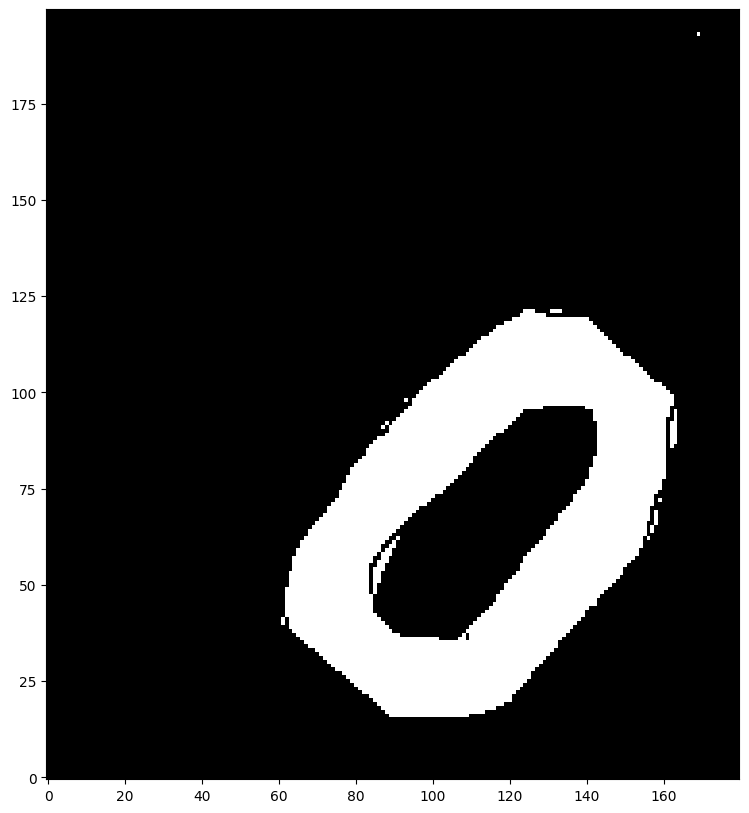

In [63]:
# O seguinte bloco de código converte os tons de cinza para preto.

imagemMapaV1 = imagemMapaV0.copy()      # Copia a imagem original
imagemMapaV1[imagemMapaV1 <= 210.] = 0  # Pixels com o limiar igual ou abaixo de 210 são convertidos para a cor preto.
imagemMapaV1[imagemMapaV1 > 210.] = 1   # Pixels com o limiar acima de 210 são convertidos para a cor branca..

alturaMapa = imagemMapaV1.shape[0]      # Salva a altura do mapa em uma variavel.
largugaMapa = imagemMapaV1.shape[1]     # Salva a largura do mapa em uma variavel.
imagemMapaV1

plt.figure(figsize=(10, 10))
plt.imshow(imagemMapaV1, cmap='gray', origin='lower') # Exibe a imagem.

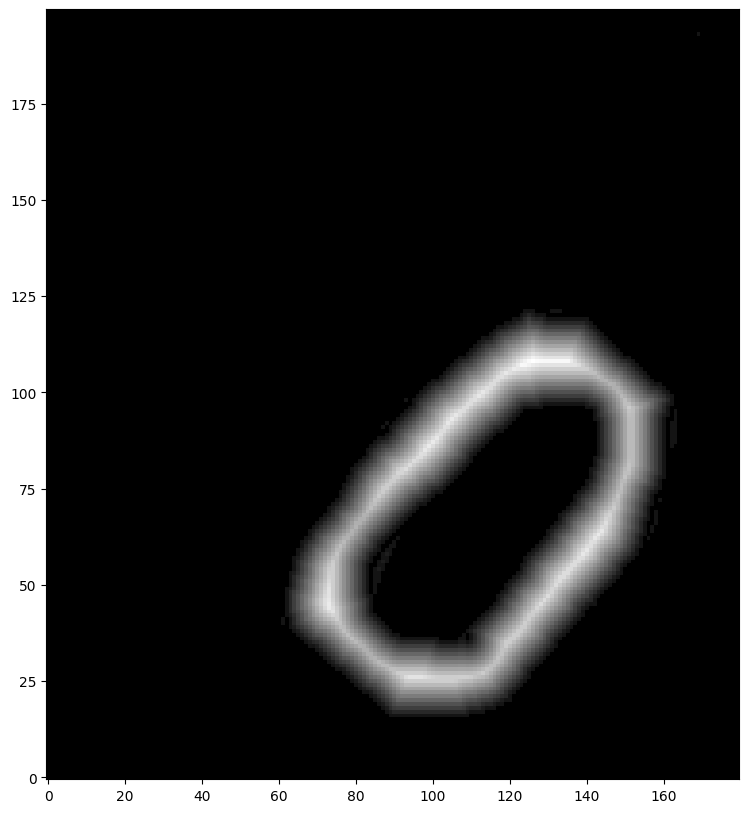

In [64]:
# O seguinte bloco calcula a Distancia Euclidiana a partir da formula √((x1 – x2)² + (y1 – y2)²) (Calcula a distancia para a parede mais próxima.)

plt.figure(figsize=(10, 10))

transformEdt= scipy.ndimage.distance_transform_edt(imagemMapaV1)
plt.imshow(transformEdt, cmap='gray', origin='lower')

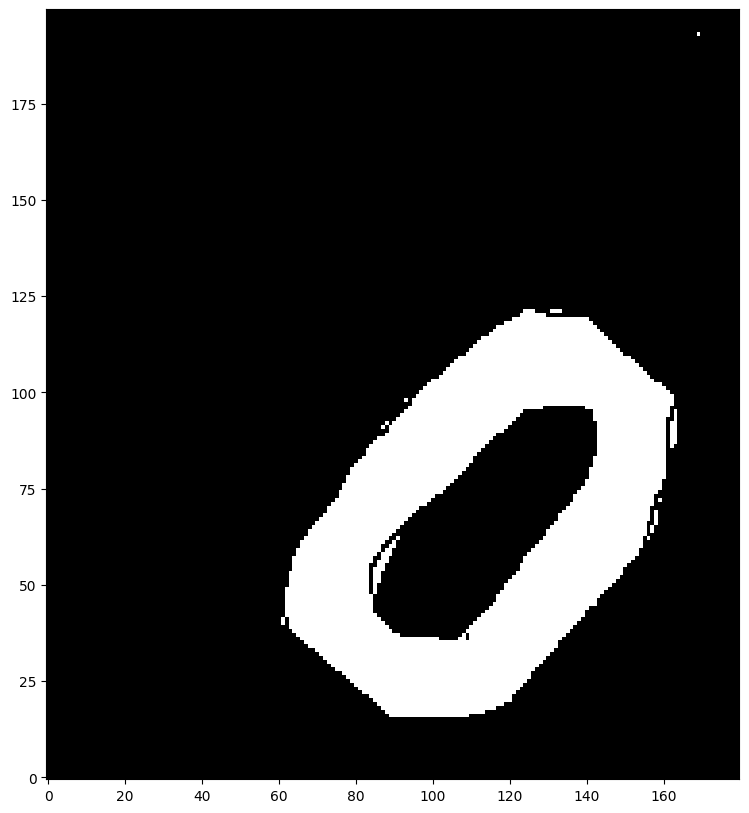

In [65]:
#Aplica um limiar que trata pixels cuja a distancia até a parede é maior que 8% da distancia maxima na imagem original como sendo de cor branca e os restantes como
# cor preta

limiar = 0.08
centros = transformEdt > limiar * transformEdt.max()
plt.figure(figsize=(10, 10))
plt.imshow(centros, origin='lower', cmap='gray')

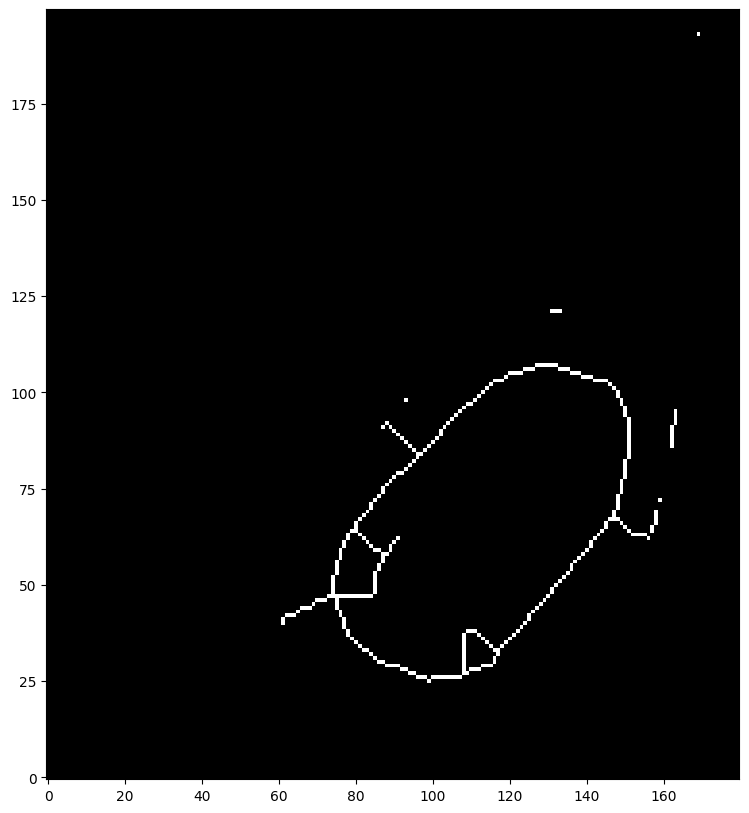

In [66]:
# Realiza de fato o calculo da linha de centro usando a função skeletonize

plt.figure(figsize=(10, 10))
linhaCentro = skeletonize(centros)
plt.imshow(linhaCentro, origin='lower', cmap='gray')

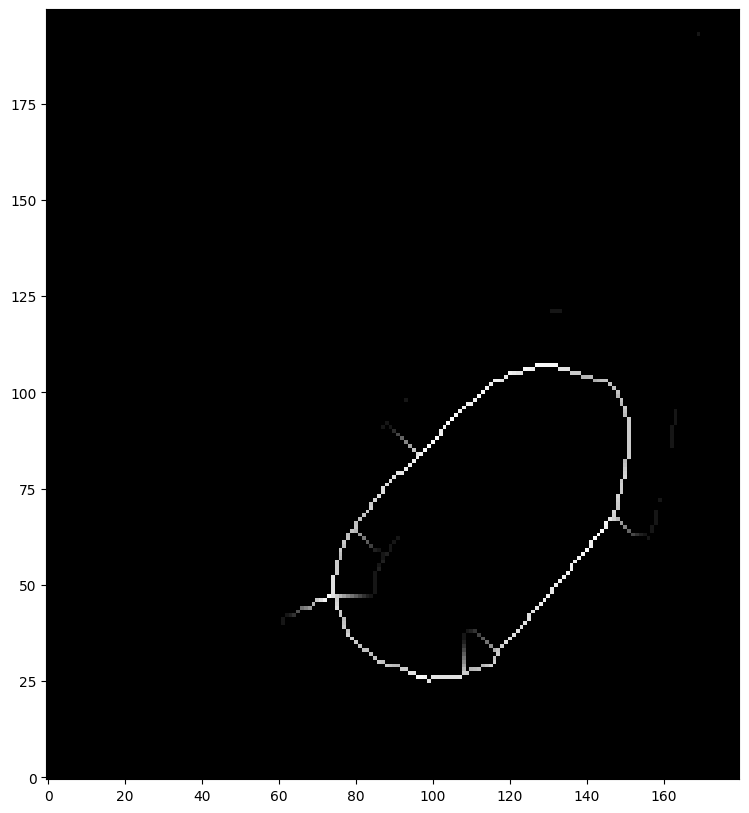

In [67]:
# Conecta a linha de centro com a distancia euclidiana dos pontos, facilitando a analise ao saber a posição de cada ponto da linha de centro.
plt.figure(figsize=(10, 10))
linhacentroEDT = np.where(linhaCentro, transformEdt, 0)
plt.imshow(linhacentroEDT, origin='lower', cmap='gray')

In [68]:
começoEsquerdaY = alturaMapa // 2 - 50

NON_EDGE = 0.0

começoesquerday = começoEsquerdaY
começoesquerdax = 0
while (linhacentroEDT[começoesquerday][começoesquerdax] == NON_EDGE): 
	começoesquerdax += 1

print(f"Posição inicial para a borda esquerdo: {começoesquerdax} {começoesquerday}")

Posição inicial para a borda esquerdo: 74 50


In [69]:
# Run DFS
import sys
sys.setrecursionlimit(20000)

visitados = {}
pontosLinhacentro = []
larguraPista = []
# direcoes = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
direcoes = [(0, -1), (-1, 0),  (0, 1), (1, 0), (-1, 1), (-1, -1), (1, 1), (1, -1) ]

posicaoInicial = (começoesquerdax, começoesquerday)

def dfs(point):
	if (point in visitados): return
	visitados[point] = True
	pontosLinhacentro.append(np.array(point))
	larguraPista.append(np.array([linhacentroEDT[point[1]][point[0]], linhacentroEDT[point[1]][point[0]]]))

	for direcao in direcoes:
		if (linhacentroEDT[point[1] + direcao[1]][point[0] + direcao[0]] != NON_EDGE and (point[0] + direcao[0], point[1] + direcao[1]) not in visitados):
			dfs((point[0] + direcao[0], point[1] + direcao[1]))

dfs(posicaoInicial)

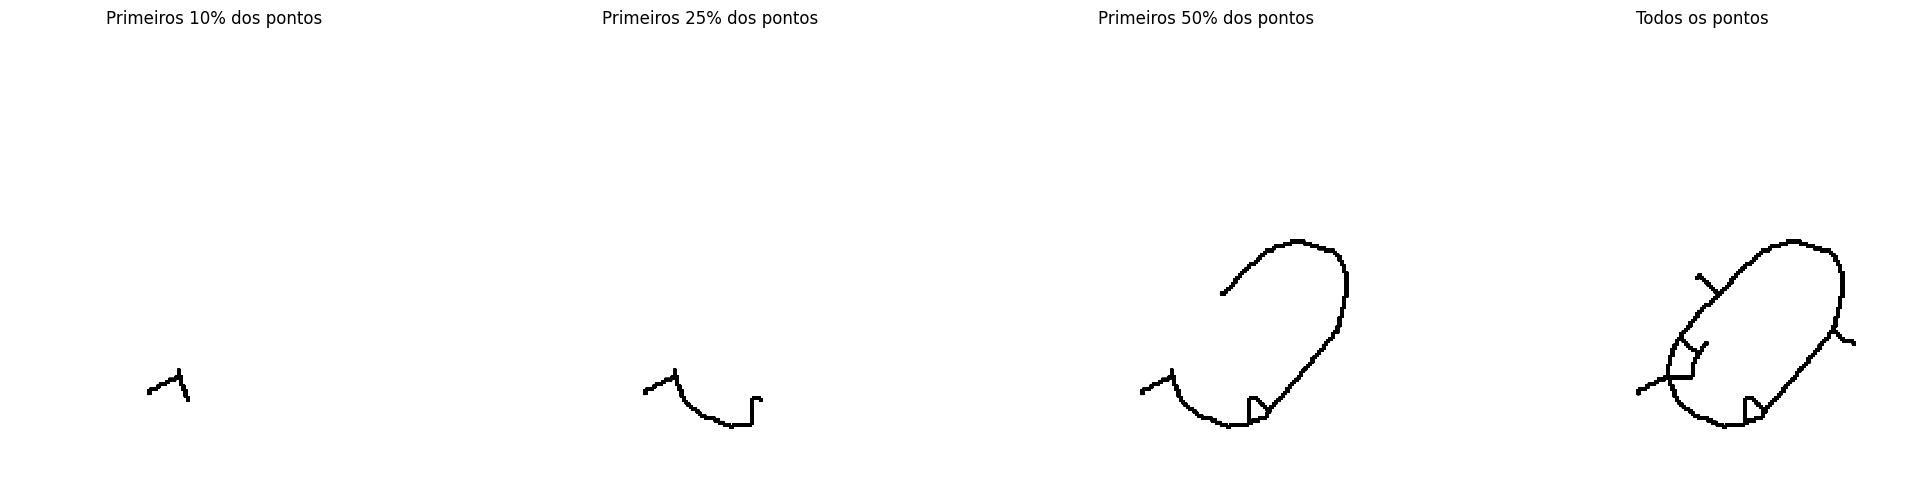

In [70]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

imagemLinhacentro = np.zeros(imagemMapaV1.shape)
for x,y in pontosLinhacentro[:len(pontosLinhacentro)//10]:
	imagemLinhacentro[y][x] = 255
ax1.imshow(imagemLinhacentro, cmap='Greys', vmax=1, origin='lower')
ax1.set_title("Primeiros 10% dos pontos")

imagemLinhacentro = np.zeros(imagemMapaV1.shape)
for x,y in pontosLinhacentro[:len(pontosLinhacentro)//4]:
	imagemLinhacentro[y][x] = 255
ax2.imshow(imagemLinhacentro, cmap='Greys', vmax=1, origin='lower')
ax2.set_title("Primeiros 25% dos pontos")

imagemLinhacentro = np.zeros(imagemMapaV1.shape)
for x,y in pontosLinhacentro[:int(len(pontosLinhacentro)/1.4)]:
	imagemLinhacentro[y][x] = 255
ax3.imshow(imagemLinhacentro, cmap='Greys', vmax=1, origin='lower')
ax3.set_title("Primeiros 50% dos pontos")

imagemLinhacentro = np.zeros(imagemMapaV1.shape)
for x,y in pontosLinhacentro:
	imagemLinhacentro[y][x] = 1000
ax4.imshow(imagemLinhacentro, cmap='Greys', vmax=1, origin='lower')
ax4.set_title("Todos os pontos")
fig.tight_layout()

In [71]:
larguraPista

[array([10., 10.]),
 array([10., 10.]),
 array([10., 10.]),
 array([10.04987562, 10.04987562]),
 array([11.04536102, 11.04536102]),
 array([10.77032961, 10.77032961]),
 array([9.8488578, 9.8488578]),
 array([8.94427191, 8.94427191]),
 array([8., 8.]),
 array([6.70820393, 6.70820393]),
 array([5.83095189, 5.83095189]),
 array([5., 5.]),
 array([3.60555128, 3.60555128]),
 array([2.23606798, 2.23606798]),
 array([1.41421356, 1.41421356]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([9.05538514, 9.05538514]),
 array([9.21954446, 9.21954446]),
 array([9.48683298, 9.48683298]),
 array([9.8488578, 9.8488578]),
 array([9., 9.]),
 array([9.05538514, 9.05538514]),
 array([8.24621125, 8.24621125]),
 array([8.54400375, 8.54400375]),
 array([8.94427191, 8.94427191]),
 array([8.60232527, 8.60232527]),
 array([9.21954446, 9.21954446]),
 array([9.21954446, 9.21954446]),
 array([8.94427191, 8.94427191]),
 array([8.60232527, 8.60232527]),
 array([8.48528137, 8.48528137]),
 array([8.4852

In [72]:
larguraPista_np = np.array(larguraPista)
waypoints = np.array(pontosLinhacentro)
print(f"Formato da largura da pista: {larguraPista_np.shape}, formato dos waypoints: {waypoints.shape}")

Formato da largura da pista: (293, 2), formato dos waypoints: (293, 2)


In [73]:
data = np.concatenate((waypoints, larguraPista_np), axis=1)
data.shape

(293, 4)

In [74]:
# load map yaml
with open(mapaYaml, 'r') as yaml_stream:
    try:
        map_metadata = yaml.safe_load(yaml_stream)
        map_resolucao = map_metadata['resolution']
        origin = map_metadata['origin']
    except yaml.YAMLError as ex:
        print(ex)

# calculate map parameters
orig_x = origin[0]
orig_y = origin[1]
# ??? Should be 0
orig_s = np.sin(origin[2])
orig_c = np.cos(origin[2])

# get the distance transform
dataTransformada = data
dataTransformada *= map_resolucao
dataTransformada += np.array([orig_x, orig_y, 0, 0])

# Safety margin
dataTransformada -= np.array([0, 0, margemLargurapista, margemLargurapista])

In [75]:
with open(f"inputs/tracks/{nomeMapa}.csv", 'wb') as fh:
    np.savetxt(fh, dataTransformada, fmt='%0.4f', delimiter=',', header='x_m,y_m,w_tr_right_m,w_tr_left_m')